In [20]:
from collections import defaultdict
import csv
from sklearn import linear_model
from sklearn.decomposition import PCA
import scipy
import scipy.optimize
import random
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd 
from IPython.display import display

In [2]:
def readCSV(path):
  f = open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')
    
def calc_model_stats(pred,label):
    
    TP,FP,TN,FN = calc_metrics(pred,label)

    # print("Stats")
    # print(TP,FP,TN,FN)

    # print("Predict N: {} ({}%)".format(TN+FN,(TN+FN)/(TP+TN+FP+FN)))
    # print("Predict P: {} ({}%)".format(TP+FP,(TP+FP)/(TP+TN+FP+FN)))

    accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Accuracy: {}".format(accuracy))
    # print("TPR: {}".format(TPR))
    # print("TNR: {}".format(TNR))
    # print("BER: {}".format(BER))
    
    return
 
def calc_metrics(predictions, labels):
    # Calculate True positives, false positives, etc.

    TP_ = numpy.logical_and(predictions, labels)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(labels))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(labels))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), labels)

    TP=sum(TP_)
    FP=sum(FP_)
    TN=sum(TN_)
    FN=sum(FN_)
    
    return TP,FP,TN,FN

def calc_error_rates(TP, FP, TN, FN):
    # Calculate accuracy, TPR, TNR and BER
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    BER = 1.0 - (TPR+TNR)/2
    
    return accuracy, TPR, TNR, BER


### Split Training Dataset into Train and Validation Datasets

In [3]:
dataset = []

for user,book,rating in readCSV("../datasets/cse258/assignment1/train_Interactions.csv"):
  dataset.append([user,book,rating])

random.shuffle(dataset)

X = [values[0:2] for values in dataset]
y = [int(values[-1]) for values in dataset]

N = len(dataset)
Ntrain = 190001

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:]

print(N, len(ytrain),len(yvalid))

200000 190001 9999


### Adopt code from Workbook 4

In [4]:
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

for user,book,rating in dataset:
    ratingsPerUser[user].append(rating)
    ratingsPerItem[book].append(rating)

N = len(Xtrain)
nUsers = len(ratingsPerUser)
nItems = len(ratingsPerItem)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

print (nUsers, nItems)
print (users[:3])
print (items[:3])

11357 7170
['u63264319', 'u26021107', 'u88966754']
['b41598050', 'b98870833', 'b30696407']


In [5]:
ratingMean = sum([y for y in ytrain])/len(ytrain)

print("Mean of ratings in training set: {}".format(ratingMean))

Mean of ratings in training set: 3.897005805232604


In [6]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for value in zip(Xtrain,ytrain):
        x,rating = value
        user = x[0]
        book = x[1]
        pred = prediction(user,book)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[user] += 2/N*diff
        dItemBiases[book] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return numpy.array(dtheta)

In [7]:
lamb_values = [1e-5,1.3e-5,1.5e-5,1.7e-5,1.8e-5,2e-5,5e-5]
MSE_valid =[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems)
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in userBiases:
            cost += lamb*userBiases[u]**2
        for i in itemBiases:
            cost += lamb*itemBiases[i]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        for value in zip(Xtrain,ytrain):
            x,rating = value
            user = x[0]
            book = x[1]
            pred = prediction(user,book)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[user] += 2/N*diff
            dItemBiases[book] += 2/N*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 1e-05
MSE = 1.473873856464982
MSE = 1.456431368523354
MSE = 1.3926990442309493
MSE = 7.992699748763671
MSE = 1.369015386525905
MSE = 1.2039672102034578
MSE = 1.201903208089255
MSE = 1.1938184067777753
MSE = 1.1642185158566818
MSE = 1.0444310777472559
MSE = 0.9961973927697352
MSE = 0.9570780562063416
MSE = 0.9424563174422734
MSE = 0.9288203623178237
MSE = 0.9226515027555446
MSE = 0.9188661478677207
MSE = 0.9181155350634062
MSE = 0.9168705154643094
MSE = 0.9170858556162015
MSE = 0.9157322652244629
MSE = 0.9149927307736362
MSE = 0.9142339137164336
MSE = 0.9141373205699372
MSE = 0.9132090084612581
MSE = 0.9797877181377072
MSE = 0.912983782825024
MSE = 0.9128937238404544
MSE = 0.9129145065234482
MSE = 0.9128795012236577
MSE = 0.9127529835819246
MSE = 0.913431250117685
MSE = 0.9128888237328417
MSE = 0.9128972885782255
MSE = 0.9128438048084605
MSE = 0.9127817050062647
MSE = 0.9128158900139834
MSE = 0.9126876402347415
MSE = 0.9128705733836319
MSE = 0.9129293007563997
MSE = 0.912905033

MSE = 0.9204773987964511
MSE = 0.9205008896861069
MSE = 0.9205641897659114
MSE = 0.9205021149886699
MSE = 0.920526938844379
MSE = 0.9205359138749829
MSE = 0.9205349594077047
MSE = 0.9205337180239839
MSE = 0.920533022976005
MSE = 0.9205380861846606
MSE = 0.9205590367903724
MSE = 0.9206010820906585
MSE = 0.9205978315337793
MSE = 0.9205898525519265
MSE = 0.920637792522961
MSE = 0.9206302504042437
MSE = 0.9206231300225696
MSE = 0.9206194989551776
MSE = 0.9211533454981179
MSE = 0.9206147349746115
MSE = 0.9206103173405396
MSE = 0.9206328784657091
MSE = 0.9205502182739058
MSE = 0.9205881626679796
MSE = 0.9205948835834266
MSE = 0.9205849873875404
MSE = 0.9208202587247981
MSE = 0.9205768682622121
MSE = 0.9205516158512381
MSE = 0.9205227000333837
MSE = 0.920482813803834
MSE = 0.9204443061738207
MSE = 0.9203738860768645
MSE = 0.9204156913896236
MSE = 0.9204257320344986
MSE = 0.9204319066346137
MSE = 0.9204264851928531
MSE = 0.9204258368546867
MSE = 0.9204257468784579
MSE = 0.9204257341417151
MSE 

MSE = 0.9249552569011027
MSE = 0.9249101714877459
MSE = 0.9249085066484912
MSE = 0.9249084444275144
MSE = 0.924908442101058
MSE = 0.9249084420140499
MSE = 0.9249084420108274
MSE = 0.9249084420106874
MSE = 0.9249084420106825
MSE = 0.924908442010685
MSE = 0.9249084420106826
MSE = 0.9249084420106825
MSE = 0.9249084420106825
MSE = 0.9249084420106828
MSE = 0.9249084420106825
MSE = 0.9249084420106825
MSE = 0.9249084420106826
MSE = 0.9249084420106825
MSE = 0.9249084420106825
MSE = 0.924908542871265
MSE = 0.9249086594490874
MSE = 0.9249091298540754
MSE = 0.9249110769735128
MSE = 0.9249390826868168
MSE = 0.9249622153199516
MSE = 0.9249732867920089
MSE = 0.9249745067977744
MSE = 0.9249744290110493
MSE = 0.9249749609816713
MSE = 0.9249780101582573
MSE = 0.9249891772413189
MSE = 0.9250185087410511
MSE = 0.9250786223689966
MSE = 0.925161568799013
MSE = 0.9250974876908933
MSE = 0.9252042137902682
MSE = 0.9251154976401953
MSE = 0.9251955471478489
MSE = 0.9251332075932325
MSE = 0.9251928380255553
MSE 

MSE = 0.9867104509815025
MSE = 0.9867094291989861
MSE = 0.9867081093267677
MSE = 0.9867104391852625
MSE = 0.9867241918666048
MSE = 0.9867605720141834
MSE = 0.9868166188258535
MSE = 0.9867749470878149
MSE = 0.9868569702638745
MSE = 0.9867953077462814
MSE = 0.9868661281270799
MSE = 0.9868102664157358
MSE = 0.9868656551361018
MSE = 0.9868202978994945
MSE = 0.986864887275064
MSE = 0.9868272802456884
MSE = 0.9868216530546479
MSE = 0.9868205712934234
MSE = 0.9868203534822335
MSE = 0.9868203092176432
MSE = 0.9868203002051508
MSE = 0.986820298369123
MSE = 0.9868202979954149
MSE = 0.9868202979190244
MSE = 0.986820297969391
MSE = 0.986820297929405
MSE = 0.9868202979210295
MSE = 0.9868202979190244
1.105219727805016


In [8]:
for lamb, MSE in zip(lamb_values ,MSE_valid):
    print ("Lamb-{} gives Validation MSE of {}".format(lamb, MSE))

Lamb-1e-05 gives Validation MSE of 1.0741282593688577
Lamb-1.3e-05 gives Validation MSE of 1.0735889944967134
Lamb-1.5e-05 gives Validation MSE of 1.0734200113625347
Lamb-1.7e-05 gives Validation MSE of 1.0737866337278643
Lamb-1.8e-05 gives Validation MSE of 1.074256054597343
Lamb-2e-05 gives Validation MSE of 1.076102050248465
Lamb-5e-05 gives Validation MSE of 1.105219727805016


In [16]:
print(len(best_theta))

print(best_theta[0])
print(best_theta[1:nUsers+1])
print(best_theta[nUsers+1:])

18528
11357
3.8115271045716583
[-0.55554225 -0.62195259 -3.27765648 ...  0.32498864 -0.19803966
 -0.00600419]
[ 0.36158633  0.64962104 -0.6115337  ...  0.02200522  0.17283829
 -0.22501942]


## Assignment 1 Kaggle Submission - Lambda=1.2e-5,  MSE=1.143, User_Name='Luke Liem'

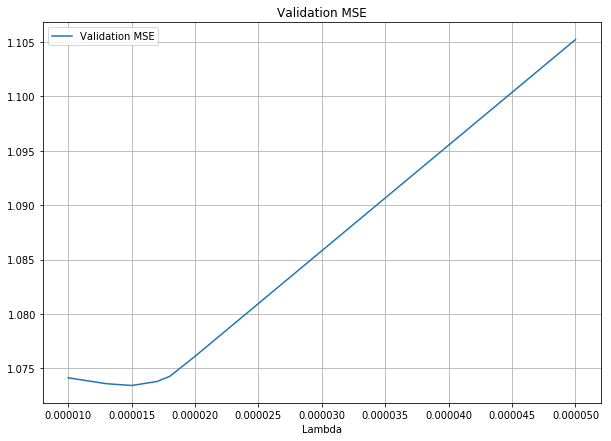

In [18]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.xlabel('Lambda')
plt.title('Validation MSE')
plt.grid(True)

plt.plot(lamb_values, MSE_valid, label='Validation MSE')

plt.legend()
plt.show()

In [24]:
best_theta

array([ 3.81233938,  0.3113362 ,  0.46095858, ..., -0.3010043 ,
       -0.01805242, -0.26187858])

In [26]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()

## PyTorch Model

### Try to replicate Assignment Result for Bias-Only Model

In [107]:
def lookup_index(list, id):
    return list.index(id)

def id_to_index_reformat(X):
    x_new = []
    
    for x in X:
        uid = x[0]
        bid = x[1]
        # print(uid,bid)
        
        uidx = lookup_index(user_ids,uid)
        bidx = lookup_index(book_ids,bid)
        # print(uidx,bidx)
        
        x_new.append([uidx,bidx])
    return x_new
    

def l2_regularize(array):
    loss = torch.sum(array ** 2.0)
    return loss

class MF(nn.Module):
    # itr = 0
    
    def __init__(self, n_user, n_item, k=1, c_vector=1.0, c_bias=1.0, writer=None, mean=0):
        super(MF, self).__init__()
        self.writer = writer
        self.k = k
        self.n_user = n_user
        self.n_item = n_item
        self.c_bias = c_bias
        self.c_vector = c_vector
        
        # gammas (users and items)
        # self.user = nn.Embedding(n_user, k)
        # self.item = nn.Embedding(n_item, k)
        
        # alpha and betas (users and items)
        self.bias_user = nn.Embedding(n_user, 1)
        self.bias_item = nn.Embedding(n_item, 1)
        self.bias = nn.Parameter(torch.ones(1))
        
        # Initialize
        self.bias.data.fill_(mean)
        self.bias_user.weight.data.fill_(0)
        self.bias_item.weight.data.fill_(0)
    
    def forward(self, train_x):
        user_id = train_x[:, 0]
        item_id = train_x[:, 1]
        # vector_user = self.user(user_id)
        # vector_item = self.item(item_id)
        
        # Pull out biases
        bias_user = self.bias_user(user_id).squeeze()
        bias_item = self.bias_item(item_id).squeeze()
        biases = (self.bias + bias_user + bias_item)
        
        # ui_interaction = torch.sum(vector_user * vector_item, dim=1)
        
        # Add bias prediction to the interaction prediction
        # prediction = ui_interaction + biases
        
        prediction = biases
        return prediction
    
    def loss(self, prediction, target):
        loss_mse = F.mse_loss(prediction, target.squeeze())
        
        # BUG - PyTorch optimizer already takes care of regularization!!!
        
        # prior_bias_user =  l2_regularize(self.bias_user.weight) * self.c_bias
        # prior_bias_item = l2_regularize(self.bias_item.weight) * self.c_bias
        # prior_user =  l2_regularize(self.user.weight) * self.c_vector
        # prior_item = l2_regularize(self.item.weight) * self.c_vector
        # total = loss_mse + prior_user + prior_item + prior_bias_user + prior_bias_item
        
        total = loss_mse
        
        # for name, var in locals().items():
        #    if type(var) is torch.Tensor and var.nelement() == 1 and self.writer is not None:
        #        self.writer.add_scalar(name, var, self.itr)
        
        return total

In [108]:
data = pd.read_csv("../datasets/cse258/assignment1/train_Interactions.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
userID    200000 non-null object
bookID    200000 non-null object
rating    200000 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


,userID,bookID,rating
0,u79354815,b14275065,4
1,u56917948,b82152306,5
2,u97915914,b44882292,5
3,u49688858,b79927466,5
4,u08384938,b05683889,2


In [28]:
book_ids = list(data['bookID'].unique())
user_ids = list(data['userID'].unique())

print(len(book_ids), book_ids[:3])
print(len(user_ids), user_ids[:3])

print(book_ids[203])
print(lookup_index(book_ids,'b52453648'))

print(user_ids[108])
print(lookup_index(user_ids,'u67309666'))

7170 ['b14275065', 'b82152306', 'b44882292']
11357 ['u79354815', 'u56917948', 'u97915914']
b52453648
203
u67309666
108


In [29]:
lamb_values = [1e-4, 8e-5, 6e-5, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
MSE_valid =[]
thetas=[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems) +  \
            [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))]
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in users:
            cost += lamb*userBiases[u]**2
            for k in range(K):
                cost += lamb*userGamma[u][k]**2
        for i in items:
            cost += lamb*itemBiases[i]**2
            for k in range(K):
                cost += lamb*itemGamma[i][k]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        dUserGamma = {}
        dItemGamma = {}
        for u in ratingsPerUser:
            dUserGamma[u] = [0.0 for k in range(K)]
        for i in ratingsPerItem:
            dItemGamma[i] = [0.0 for k in range(K)]
        for value in zip(Xtrain,ytrain):
            x,rating = value
            u = x[0]
            i = x[1]
            pred = prediction(u, i)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[u] += 2/N*diff
            dItemBiases[i] += 2/N*diff
            for k in range(K):
                dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
                dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
            for k in range(K):
                dUserGamma[u][k] += 2*lamb*userGamma[u][k]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
            for k in range(K):
                dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        for u in users:
            dtheta += dUserGamma[u]
        for i in items:
            dtheta += dItemGamma[i]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))
    thetas.append(theta)  # save thetas

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 0.0001
MSE = 1.472911714464408
MSE = 1.4555257179723937
MSE = 1.3919639784789475
MSE = 7.490819683692902
MSE = 1.376739341545793
MSE = 1.2204798698615391
MSE = 1.218624237734379
MSE = 1.211367353215079
MSE = 1.1849901152863394
MSE = 1.0959368812255847
MSE = 1.0763647182868918
MSE = 1.0639778627822707
MSE = 1.0646558928619114
MSE = 1.0653861842715504
MSE = 1.0645559180032453
MSE = 1.0635716123352426
MSE = 1.063520431831953
MSE = 1.064112002933143
MSE = 1.063545660268213
MSE = 1.0635222496589456
MSE = 1.0635205667898529
MSE = 1.0635204418734128
MSE = 1.0635204325792058
MSE = 1.0635204318876086
MSE = 1.0635204318360503
MSE = 1.0635204318322693
MSE = 1.0635204318322953
MSE = 1.0635204318342046
MSE = 1.0635204318324025
MSE = 1.063520431832299
MSE = 1.0635204318322953
Save best theta...
1.1775359456991676
Lambda = 8e-05
MSE = 1.476119044755357
MSE = 2.3379034429529293
MSE = 1.472791016758991
MSE = 1.4725847660744202
MSE = 1.4720051472399327
MSE = 1.4705350695072075
MSE = 1.466688117

MSE = 1.0755826536727273
MSE = 1.064329163914763
MSE = 1.0459837725756636
MSE = 1.0264969843614045
MSE = 1.0318745364152961
MSE = 1.0272989867652491
MSE = 1.0269275848184884
MSE = 1.0128956860437517
MSE = 1.011448653415465
MSE = 1.008924831963294
MSE = 1.0043755410997557
MSE = 1.0204616478382984
MSE = 1.0060045724344557
MSE = 1.0041767290391173
MSE = 0.9966446756779305
MSE = 0.994257001788545
MSE = 0.9935237754136971
MSE = 0.9940148315645186
MSE = 0.9946703221290986
MSE = 0.9952191086694048
MSE = 0.9956543269167126
MSE = 1.001204375742941
MSE = 0.9953873843464361
MSE = 0.9939895061598008
MSE = 0.9907717704898347
MSE = 0.9896108641437549
MSE = 0.9884742721900621
MSE = 0.9877533668737032
MSE = 1.1181419652324187
MSE = 0.9876005975426527
MSE = 0.9877715887676483
MSE = 0.9892533410685949
MSE = 0.9881362146679821
MSE = 0.9902859920172785
MSE = 0.9884264611126778
MSE = 0.9884870671825574
MSE = 0.9883218371742423
MSE = 1.0015371746649422
MSE = 0.9883138502855044
MSE = 0.9876978935705786
MSE =

MSE = 0.9170057946779203
MSE = 0.9162376545275299
MSE = 0.91450882320836
MSE = 0.8950190269023306
MSE = 0.9086502577825432
MSE = 0.909068951479074
MSE = 0.9088098129966606
MSE = 0.9089679080349716
MSE = 0.9087998766392931
MSE = 0.9081875343910999
MSE = 0.9070125909552779
MSE = 0.9063289623135159
MSE = 0.9038696422650696
MSE = 0.9054282962532146
MSE = 0.906608545605546
MSE = 0.9056674985256213
MSE = 0.9059335481625073
MSE = 0.9060669037556501
MSE = 0.9061577910255978
MSE = 0.9059417163286224
MSE = 0.9075279164282988
MSE = 0.9057096767353222
MSE = 0.9048199155898777
MSE = 0.903607990628909
MSE = 0.9029395521262881
MSE = 0.9028035709619533
MSE = 0.9026951043453832
MSE = 0.9021823485513939
MSE = 1.1643824958205886
MSE = 0.9022408843387715
MSE = 0.9013647071620187
MSE = 0.8942106219150132
MSE = 0.8985093159338395
MSE = 0.8983643693722195
MSE = 0.8980775785935566
MSE = 0.8974979295039172
MSE = 0.8976465622763516
MSE = 0.897580344034824
MSE = 0.8974843500963314
MSE = 0.8974220195531337
MSE = 

MSE = 0.8585964470123668
MSE = 0.8569704340515758
MSE = 0.8529107140973115
MSE = 0.8549433884808229
MSE = 0.8544046378971571
MSE = 0.8527513277514053
MSE = 0.8487485247848395
MSE = 0.8509424682967276
MSE = 0.848856656726996
MSE = 0.849396890321369
MSE = 0.9424481667120903
MSE = 0.850033511897837
MSE = 0.8495170202427994
MSE = 0.8462082052799454
MSE = 0.8458012040307595
MSE = 0.8440596209997014
MSE = 0.8445041994547856
MSE = 0.8439252591303092
MSE = 0.8442123151422326
MSE = 0.8447481616592483
MSE = 0.8452808952540861
MSE = 0.8467239340213041
MSE = 0.8455176308786582
MSE = 0.846349735916283
MSE = 0.845949684109099
MSE = 0.8455227441242865
MSE = 0.8448138505641233
MSE = 0.8442061030273547
MSE = 0.8431387941374671
MSE = 0.8432321205772354
MSE = 0.843057941364262
MSE = 0.8423814947577712
MSE = 0.8424894994014707
MSE = 0.8429451140883399
MSE = 0.8444615278282847
MSE = 0.8430780993864094
MSE = 0.8435527798003968
MSE = 0.8429775995122187
MSE = 0.8432165448026745
MSE = 0.843605025344151
MSE = 0

MSE = 0.8283960024157585
MSE = 0.9172021408359706
MSE = 0.8272573240987943
MSE = 0.8263063453814898
MSE = 0.825043291851139
MSE = 0.825257605326523
MSE = 0.8347147350787698
MSE = 0.8260234414909252
MSE = 0.8221730573868835
MSE = 0.8212654580055114
MSE = 0.8204637650502777
MSE = 0.821503884887902
MSE = 0.8214571887082184
MSE = 0.8213369394955304
MSE = 0.8222893039657382
MSE = 0.8230427272835671
MSE = 0.8232554013849219
MSE = 0.839008151974039
MSE = 0.8236292945591295
MSE = 0.822186445688762
MSE = 0.957427333142911
MSE = 0.822345914946513
MSE = 0.8195916292739747
MSE = 0.8192500798832865
MSE = 0.8193450037371821
MSE = 0.8179092469022592
MSE = 0.8180791317308784
MSE = 0.817820476921967
MSE = 0.8179925103766029
MSE = 0.8181847090186192
MSE = 0.818481499373656
MSE = 0.8187797325752159
MSE = 0.8187998219756946
MSE = 0.8180680734356542
MSE = 8.257795888758272
MSE = 0.8179406989120317
MSE = 0.8163096519581409
MSE = 0.8149502814502254
MSE = 0.8144973511034558
MSE = 0.8143919656717177
MSE = 0.81

MSE = 1.4595824051087134
MSE = 1.4397500587976888
MSE = 1.3958808607770867
MSE = 1.3201442179703786
MSE = 1.238900997949577
MSE = 1.199979607059792
MSE = 1.1943816447484816
MSE = 1.1943200713684774
MSE = 1.1939628952474237
MSE = 1.1904788023338346
MSE = 1.1816416607218894
MSE = 1.1596152235876558
MSE = 1.1217657399697962
MSE = 1.0814962650911468
MSE = 1.0606819246884762
MSE = 10.998205444381815
MSE = 1.0570501462267918
MSE = 1.0552037913433439
MSE = 1.0535158122587651
MSE = 1.0445794390613892
MSE = 1.0242352002403134
MSE = 0.9997590593104911
MSE = 0.9822145219235967
MSE = 0.9710048923998245
MSE = 0.966822833445079
MSE = 0.9602826893960739
MSE = 0.9504815259330631
MSE = 4.63473515414855
MSE = 0.9480860404693756
MSE = 0.9447420140428063
MSE = 0.9438585983366932
MSE = 0.9412432217640337
MSE = 0.939259803445872
MSE = 0.9339069739382438
MSE = 0.9274463531232949
MSE = 0.9262053217040933
MSE = 0.925145692871793
MSE = 0.9523044579794122
MSE = 0.9239233075045008
MSE = 0.9225338803367421
MSE = 0

MSE = 0.7365990466393793
MSE = 0.7285722906808718
MSE = 0.7287755322378261
MSE = 0.7283643840437146
MSE = 0.7280864000680667
MSE = 0.7282006146160144
MSE = 0.7280554916028112
MSE = 0.7278948172034228
MSE = 0.7279161372098909
MSE = 0.7283592734165195
MSE = 0.7287388073895867
MSE = 0.7956188506385735
MSE = 0.7287617793193003
MSE = 0.7290820105964395
MSE = 0.7291529465902408
MSE = 0.7290382723648698
MSE = 0.728666515167056
MSE = 0.7286351922814971
MSE = 0.7284692761407716
MSE = 0.7279506956873092
MSE = 0.7273027354909901
MSE = 0.7266995863371288
MSE = 0.7263446932713524
MSE = 0.7262414295582665
MSE = 0.7261495013544863
MSE = 0.7258339263108953
MSE = 0.7256499924540827
MSE = 0.7252610623393204
MSE = 0.726585713991451
MSE = 0.7252988989386829
MSE = 0.7240553717687174
MSE = 0.7234254164425031
MSE = 0.7230992545853282
MSE = 0.723140441847862
MSE = 0.7230407579231628
MSE = 0.7290950939549644
MSE = 0.7231899306204719
MSE = 0.7232441594345794
MSE = 0.7232905472334579
MSE = 0.7231928716769518
MSE

MSE = 0.7125437363547896
MSE = 0.7125002551050066
MSE = 0.7124973546313075
MSE = 0.712510934540091
MSE = 0.7125361272593422
MSE = 0.7125384734380659
MSE = 0.7181373651051655
MSE = 0.7125736149313169
MSE = 0.7125871017479672
MSE = 0.7126347340217359
MSE = 0.7125951720126529
MSE = 0.7125874253326114
MSE = 0.7125809026435281
MSE = 0.7125624554872824
MSE = 0.712663025823218
MSE = 0.7125669583629339
MSE = 0.7125604413755442
MSE = 0.7125647757106316
MSE = 0.7125813794626209
MSE = 0.712605835404076
MSE = 0.7125835755229981
MSE = 0.7125728882555419
MSE = 0.7125639761276387
MSE = 0.7125359919739824
MSE = 0.7125798485228243
MSE = 0.7125112086969089
MSE = 0.7124774057296223
MSE = 0.7124197155425187
MSE = 0.7124304075624152
MSE = 0.7124111220763961
MSE = 0.7123747494617391
MSE = 0.7123751494868648
MSE = 0.7123784657322524
MSE = 0.7123740957232341
MSE = 0.7128203100912216
MSE = 0.7123684091461245
MSE = 0.7123586132364019
MSE = 0.712316629808848
MSE = 0.7122038008646362
MSE = 0.7134938773240527
MSE 

MSE = 0.7101298082159404
MSE = 0.7101298082108485
MSE = 0.7101298082142109
MSE = 0.7101298082115223
MSE = 0.710129808210916
MSE = 0.7101298082108485
1.293056691437069


In [45]:
train_x = id_to_index_reformat(Xtrain)
valid_x = id_to_index_reformat(Xvalid)

train_y = ytrain
valid_y = yvalid

print (Xtrain[10:15], train_x[10:15])
print (Xvalid[10:15], valid_x[10:15])


[['u35030794', 'b34243773'], ['u03311330', 'b61525389'], ['u25185712', 'b48026111'], ['u19601482', 'b43546779'], ['u94100354', 'b39405098']] [[2423, 3488], [903, 1692], [4260, 2126], [6012, 983], [6456, 1313]]
[['u46244592', 'b68658762'], ['u77810949', 'b76915592'], ['u86231895', 'b99482210'], ['u64961313', 'b25015745'], ['u38737686', 'b54883246']] [[7059, 3762], [7189, 272], [7070, 1880], [520, 2675], [6883, 1034]]


In [42]:
# Basic QC

for i in range(5):
    index = random.randint(0, len(train_x))
    uid = train_x[index][0]
    bid = train_x[index][1]
    print(index, uid, bid, user_ids[uid],book_ids[bid])
    print(Xtrain[index])


4355 11283 315 u62498455 b39969042
['u62498455', 'b39969042']
28854 4784 25 u90197731 b50835324
['u90197731', 'b50835324']
6355 5148 1935 u05719364 b40443264
['u05719364', 'b40443264']
164132 9379 117 u88101401 b92932322
['u88101401', 'b92932322']
153147 485 3043 u45516241 b30970717
['u45516241', 'b30970717']


In [110]:
from random import shuffle

# Hyperparameters
lr = 1e-2

# New parameter for regularizing bias
lamb = 1e-5
batch_size = 1024

n_user = len(ratingsPerUser)
n_item = len(ratingsPerItem)

cuda = torch.cuda.is_available()

model = MF(n_user, n_item, mean=ratingMean)
if cuda:
    model.cuda()
    
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=lamb, momentum=0.9)

def chunks(X, Y, size):
    """Yield successive n-sized chunks from l."""
    starts = list(range(0, len(X), size))
    shuffle(starts)
    for i in starts:
        yield (X[i:i + size], Y[i:i + size])
        
losses = []
valid_losses = []

for epoch in range(1000+1):
    
    i = 0
    for feature, target in chunks(np.array(train_x), np.array(train_y), batch_size):
        # This zeros the gradients on every parameter. 
        # This is easy to miss and hard to troubleshoot.
        optimizer.zero_grad()
        # Convert 
        feature = Variable(torch.from_numpy(feature))
        target = Variable(torch.from_numpy(target).type(torch.FloatTensor))
        
        if cuda:
            feature = feature.cuda()
            target = target.cuda()
            
        # model in training mode    
        model.train()
            
        # Compute a prediction for these features
        prediction = model.forward(feature)
        # Compute a loss given what the true target outcome was
        loss = model.loss(prediction, target)
        # break
        # Backpropagate: compute the direction / gradient every model parameter
        # defined in your __init__ should move in in order to minimize this loss
        # However, we're not actually changing these parameters, we're just storing
        # how they should change.

        loss.backward()
        # Now take a step & update the model parameters. The optimizer uses the gradient at 
        # defined on every parameter in our model and nudges it in that direction.
        optimizer.step()
        
        if i%100 == 0 and epoch%10 == 0:
            print("Epoch[{}] Iteration[{}] Training Loss: {:.3f}".format(epoch, i, loss.data))

        # Record the loss per example
        losses.append(loss.cpu().data.numpy() / len(feature))
        
        if i%100 == 0 and epoch%10 == 0:
            val_feature = torch.from_numpy(np.array(valid_x))
            val_target = torch.from_numpy(np.array(valid_y)).type(torch.FloatTensor)
            
            if cuda:
                val_feature = val_feature.cuda()
                val_target = val_target.cuda()
                
            # model in test mode    
            model.eval()

            val_pred = model.forward(val_feature)
            val_loss = model.loss(val_pred, val_target)
            print("Epoch[{}] Validation Loss: {:.3f} ".format(epoch, val_loss.data))
            
            # Record the validation loss per example
            valid_losses.append(val_loss.cpu().data.numpy()/len(val_feature))

        i += 1


Epoch[0] Iteration[0] Training Loss: 1.703
Epoch[0] Validation Loss: 1.485 
Epoch[0] Iteration[100] Training Loss: 1.442
Epoch[0] Validation Loss: 1.482 
Epoch[10] Iteration[0] Training Loss: 1.485
Epoch[10] Validation Loss: 1.441 
Epoch[10] Iteration[100] Training Loss: 1.481
Epoch[10] Validation Loss: 1.439 
Epoch[20] Iteration[0] Training Loss: 1.261
Epoch[20] Validation Loss: 1.405 
Epoch[20] Iteration[100] Training Loss: 1.333
Epoch[20] Validation Loss: 1.403 
Epoch[30] Iteration[0] Training Loss: 1.493
Epoch[30] Validation Loss: 1.376 
Epoch[30] Iteration[100] Training Loss: 1.090
Epoch[30] Validation Loss: 1.373 
Epoch[40] Iteration[0] Training Loss: 1.421
Epoch[40] Validation Loss: 1.348 
Epoch[40] Iteration[100] Training Loss: 1.343
Epoch[40] Validation Loss: 1.347 
Epoch[50] Iteration[0] Training Loss: 1.158
Epoch[50] Validation Loss: 1.325 
Epoch[50] Iteration[100] Training Loss: 1.244
Epoch[50] Validation Loss: 1.324 
Epoch[60] Iteration[0] Training Loss: 1.188
Epoch[60] Va

Epoch[510] Iteration[0] Training Loss: 0.921
Epoch[510] Validation Loss: 1.087 
Epoch[510] Iteration[100] Training Loss: 0.966
Epoch[510] Validation Loss: 1.087 
Epoch[520] Iteration[0] Training Loss: 0.980
Epoch[520] Validation Loss: 1.086 
Epoch[520] Iteration[100] Training Loss: 0.979
Epoch[520] Validation Loss: 1.086 
Epoch[530] Iteration[0] Training Loss: 0.997
Epoch[530] Validation Loss: 1.085 
Epoch[530] Iteration[100] Training Loss: 0.902
Epoch[530] Validation Loss: 1.085 
Epoch[540] Iteration[0] Training Loss: 1.026
Epoch[540] Validation Loss: 1.085 
Epoch[540] Iteration[100] Training Loss: 1.057
Epoch[540] Validation Loss: 1.085 
Epoch[550] Iteration[0] Training Loss: 0.994
Epoch[550] Validation Loss: 1.084 
Epoch[550] Iteration[100] Training Loss: 0.964
Epoch[550] Validation Loss: 1.084 
Epoch[560] Iteration[0] Training Loss: 1.017
Epoch[560] Validation Loss: 1.084 
Epoch[560] Iteration[100] Training Loss: 0.880
Epoch[560] Validation Loss: 1.084 
Epoch[570] Iteration[0] Trai

In [112]:
model.cpu()

print(ratingMean)
print(best_theta[0])
print(model.bias)


3.897005805232604
3.8115271045716583
Parameter containing:
tensor([3.8112], requires_grad=True)
